
(tutorials-polar)=

# Phonon and dielectric properties of AlAs

In this tutorial you will learn how to calculate the phonon and dielectric properties of AlAs using `aiida-vibroscopy`.

Let's get started!

In [15]:
from local_module import load_temp_profile

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
data = load_temp_profile(
    name="polar-tutorial",
    add_computer=True,
    add_pw_code=True,
    add_phonopy_code=True,
    add_sssp=True,
)

## Importing the structure from COD

Let's import the silicon structure from the COD database via AiiDA.

In [16]:
from aiida.plugins import DbImporterFactory

CodDbImporter = DbImporterFactory('cod')

cod = CodDbImporter()
results = cod.query(id='1540257') # AlAs 1540257
structure = results[0].get_aiida_structure() # it has 8 atoms


## The `HarmonicWorkChain`

For polar materials, the __non-analytical constants__ (NAC), i.e. Born effective charges and dielectric tensors, must be accounted when interpolating the phonon band structure. Moreover in AlAs, since it is non-centrosymmetric, a non zero $\chi^{(2)}$ is present.

Let's import the WorkChain and run it! We use the `get_builder_from_protocol` to get a __prefilled__ builder with __all inputs__. These inputs should be considered __not as converged parameters__, but as a good starting point. You may also need to tweak some parameters, e.g. add magnetization etc., depending on your case. 

In [17]:
from aiida.orm import List
from aiida.plugins import WorkflowFactory
from aiida.engine import run_get_node

from aiida_vibroscopy.common.properties import PhononProperty

HarmonicWorkChain = WorkflowFactory("vibroscopy.phonons.harmonic")

builder = HarmonicWorkChain.get_builder_from_protocol(
    pw_code=data.pw_code,
    structure=structure,
    protocol="fast",
    phonopy_code=data.phonopy_code,
    phonon_property=PhononProperty.BANDS,
)
builder.phonon.supercell_matrix = List([1,1,1]) # this can be 2,2,2, but we save some time JUST FOR THE TUTORIAL
builder.dielectric.property = "raman" # this way it will compute also third order derivatives

results, calc = run_get_node(builder)

Report: [325|HarmonicWorkChain|run_phonon]: submitting `PhononWorkChain` <PK=331>
Report: [325|HarmonicWorkChain|run_dielectric]: submitting `DielectricWorkChain` <PK=335>
Report: [335|DielectricWorkChain|run_base_scf]: launching base scf PwBaseWorkChain<348>
Report: [348|PwBaseWorkChain|run_process]: launching PwCalculation<352> iteration #1
Report: [331|PhononWorkChain|run_base_supercell]: launching base supercell scf PwBaseWorkChain<357>
Report: [357|PwBaseWorkChain|run_process]: launching PwCalculation<360> iteration #1
Report: [348|PwBaseWorkChain|results]: work chain completed after 1 iterations
Report: [348|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
Report: [335|DielectricWorkChain|run_nscf]: launching base scf PwBaseWorkChain<369>
Report: [369|PwBaseWorkChain|run_process]: launching PwCalculation<372> iteration #1
Report: [357|PwBaseWorkChain|results]: work chain completed after 1 iterations
Report: [357|PwBaseWorkChain|on_terminated]: remote folders wil

/aiida-plugins/aiida-vibroscopy/src/aiida_vibroscopy/calculations/symmetry.py:162: UserWarning: Symmetry of dChi/dr tensors is largely broken. 
The max difference is:
12.88765439365443
  warnings.warn('\n'.join(lines))
/aiida-plugins/aiida-vibroscopy/src/aiida_vibroscopy/calculations/symmetry.py:162: UserWarning: Symmetry of dChi/dr tensors is largely broken. 
The max difference is:
117.75652293854249
  warnings.warn('\n'.join(lines))
/aiida-plugins/aiida-vibroscopy/src/aiida_vibroscopy/calculations/symmetry.py:162: UserWarning: Symmetry of dChi/dr tensors is largely broken. 
The max difference is:
153.75196663153494
  warnings.warn('\n'.join(lines))


Report: [335|DielectricWorkChain|on_terminated]: cleaned remote folders of calculations: 352 372 409 412 442 445 464 467
Report: [325|HarmonicWorkChain|run_phonopy]: submitting `PhonopyCalculation` <PK=515>
Report: [325|HarmonicWorkChain|on_terminated]: cleaned remote folders of calculations: 360 387 390 352 372 409 412 442 445 464 467 515


As we computed the __phonon dispersion__, we can easily plot it as follows:

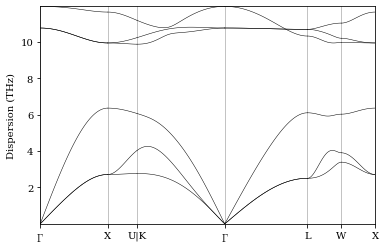

In [18]:
calc.outputs.output_phonopy.phonon_bands.show_mpl()

Hurray! We obtained the LO-TO splitting at the $\Gamma$ point!

## Born charges, dielectric, non-linear optical susceptibility and Raman tensors

We finally can explore all the electric field related derivatives for this material.

In [19]:
vibro = calc.outputs.vibrational_data.numerical_accuracy_4
print("The Born effective charges: ", "\n", vibro.born_charges.round(5))

The Born effective charges:  
 [[[ 2.14436  0.       0.     ]
  [-0.       2.14436 -0.     ]
  [-0.      -0.       2.14436]]

 [[-2.14436 -0.      -0.     ]
  [ 0.      -2.14436 -0.     ]
  [ 0.       0.      -2.14436]]]


In [20]:
print("The dielectric tensor: ", "\n", vibro.dielectric.round(5))

The dielectric tensor:  
 [[ 8.38413 -0.      -0.     ]
 [-0.       8.38413  0.     ]
 [-0.      -0.       8.38413]]


In [21]:
print("The non-linear optical susceptibility tensor (pm/V): ", "\n", vibro.nlo_susceptibility.round(5))

The non-linear optical susceptibility tensor (pm/V):  
 [[[-0.       0.       0.     ]
  [ 0.       0.      42.46219]
  [ 0.      42.46219  0.     ]]

 [[-0.       0.      42.46219]
  [ 0.       0.       0.     ]
  [42.46219  0.       0.     ]]

 [[ 0.      42.46219  0.     ]
  [42.46219  0.       0.     ]
  [ 0.       0.       0.     ]]]


In [22]:
vol = vibro.get_unitcell().get_cell_volume()
print("The Raman tensors (Angstrom^2): ", "\n", vibro.raman_tensors.round(5)*vol)

The Raman tensors (Angstrom^2):  
 [[[[ 0.         -0.         -0.        ]
   [-0.         -0.         -6.38522341]
   [-0.         -6.38522341 -0.        ]]

  [[-0.         -0.         -6.38522341]
   [-0.         -0.          0.        ]
   [-6.38522341  0.         -0.        ]]

  [[-0.         -6.38522341 -0.        ]
   [-6.38522341 -0.         -0.        ]
   [-0.         -0.         -0.        ]]]


 [[[-0.         -0.          0.        ]
   [-0.          0.          6.38522341]
   [ 0.          6.38522341  0.        ]]

  [[ 0.         -0.          6.38522341]
   [-0.         -0.         -0.        ]
   [ 6.38522341 -0.          0.        ]]

  [[ 0.          6.38522341  0.        ]
   [ 6.38522341 -0.          0.        ]
   [ 0.          0.          0.        ]]]]


## Comparison with experiments

Here the comparison with experiments. (have a look at [I. Souza et al., _Phys. Rev. Lett._, __89__, 11 (__2002__)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.89.117602) and references therein)

In [23]:
print("Dielectric: ", "\n", "DFT: ", vibro.dielectric.round(1)[0,0], "\tExperiment: 9.6")

Dielectric:  
 DFT:  8.4 	Experiment: 9.6


In [24]:
print("Born charges*: ", "\n", "DFT: ", vibro.born_charges.round(2)[0,0,0], "\tExperiment: 2.14")

Born charges*:  
 DFT:  2.14 	Experiment: 2.14


In [25]:
print("Non-linear optical susceptibility (pm/V): ", "\n", "DFT: ", vibro.nlo_susceptibility.round(0)[0,1,2], "\tExperiment: 64")

Non-linear optical susceptibility (pm/V):  
 DFT:  42.0 	Experiment: 64


### Raman polarizability

We can also obtain the Raman polarizability tensor, both for the TO and LO modes. We can only compare with other DFT results, cause there are no available experimental data.

In [29]:
print("TO Raman polarizability tensor (Angstrom^2): ", "\n", "DFT: ", (vibro.raman_tensors[1,0,1,2]*vol).round(2), "\tVeithen et al. (2005): 8.48")

TO Raman polarizability tensor (Angstrom^2):  
 DFT:  6.39 	Veithen et al. (2005): 8.48


In [27]:
import numpy as np

alpha, _, _ = vibro.run_raman_susceptibility_tensors(nac_direction=[1,1,0])
reduced_mass = (26.981539*74.9216)/(26.981539+74.9216)
prefactor = np.sqrt(reduced_mass*vol)
alpha = alpha*prefactor

print("LO Raman polarizability tensor (Angstrom^2): ", "\n", "DFT: ", -alpha[2,0,1].round(2), "\tVeithen et al. (2005): 12.48")

LO Raman polarizability tensor (Angstrom^2):  
 DFT:  16.74 	Veithen et al. (2005): 12.48


::: {note} Why do our results differ from the one of Veithen?
:class: dropdown

The reason why we have discrepancies is mostly due to the fact we have _unconverged_ results. These tensors, being a third order derivative of the total energy, usually require a much denser k point sampling. Moreover, we also did not do the followings:
- A tight relaxation of the cell; volume can modify significantly these properties.
- Used the same functional as in other simulations, which eventually leads to different results.
- Used a proper set of inputs: it's just a tutorial, and we don't want to wait forever (i.e. 5 minutes are too much already).
:::

## Analysing the workflow

Many things happened for computing this phonon band structure. Let's inspect the process tree.

In [28]:
%verdi process status {calc.pk}

HarmonicWorkChain<325> Finished [0] [4:if_(should_run_phonopy)(1:inspect_phonopy)]
    ├── generate_preprocess_data<326> Finished [0]
    ├── PhononWorkChain<331> Finished [0] [7:if_(should_run_phonopy)]
    │   ├── generate_preprocess_data<336> Finished [0]
    │   ├── get_supercell<349> Finished [0]
    │   ├── create_kpoints_from_distance<354> Finished [0]
    │   ├── PwBaseWorkChain<357> Finished [0] [3:results]
    │   │   └── PwCalculation<360> Finished [0]
    │   ├── get_supercells_with_displacements<378> Finished [0]
    │   ├── PwBaseWorkChain<382> Finished [0] [3:results]
    │   │   └── PwCalculation<387> Finished [0]
    │   ├── PwBaseWorkChain<384> Finished [0] [3:results]
    │   │   └── PwCalculation<390> Finished [0]
    │   └── generate_phonopy_data<424> Finished [0]
    ├── DielectricWorkChain<335> Finished [0] [11:results]
    │   ├── create_kpoints_from_distance<337> Finished [0]
    │   ├── create_directional_kpoints<341> Finished [0]
    │   ├── create_directiona

## Final considerations

We managed to compute the phonons and dielectric properties of AlAs __fully__ ___ab initio___! :tada:

:::{admonition} Learn more and in details
:class: hint

To learn the full sets of inputs, to use proficiently the `get_builder_from_protocol` and more, have a look at the following sections:
- [Specific how tos](howto/workflows/phonons/harmonic.md)
- [General information of the implemented workchain](topics/workflows/phonons/harmonic.md)